In [47]:
import pandas as pd
import re
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
from torch.utils.data import WeightedRandomSampler
import numpy as np 



In [54]:
# --- 0. Charger le modèle spaCy pour le français ---

nlp_fr = spacy.load('fr_core_news_sm')

In [55]:
# --- 1. Charger et Préparer les Données ---

df = pd.read_csv('../../data/data_vrsmall_fr.csv')

print("Aperçu initial des données:")
print(df.head())
print(f"\nDimensions du DataFrame: {df.shape}")
print(f"\nDistribution des labels:\n{df['label'].value_counts(normalize=True)}")

def clean_text(text):
    text = str(text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s\.\?,!àâéèêëîïôûùüçÀÂÉÈÊËÎÏÔÛÙÜÇ\']', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_question'] = df['question'].apply(clean_text)
df['cleaned_answer'] = df['answer'].apply(clean_text)


print(df[['cleaned_question', 'cleaned_answer', 'label']].head())


Aperçu initial des données:
                                            question  \
0               Quelle est votre taille habituelle ?   
1  Souhaitez-vous essayer autre chose ou passer e...   
2               Quelle est votre taille habituelle ?   
3               Quelle est votre taille habituelle ?   
4  Bonjour, que puis-je faire pour vous aujourd'h...   

                                              answer  label  
0              La taille de ce mensonge est énorme !      0  
1  Un style intemporel, que je pourrai garder lon...      0  
2                        En caisse, s'il vous plaît.      0  
3  Oui, je cherche quelque chose en jean, un styl...      0  
4              Un style ethnique chic, si vous avez.      0  

Dimensions du DataFrame: (3099, 3)

Distribution des labels:
label
0    0.83414
1    0.16586
Name: proportion, dtype: float64
                                    cleaned_question  \
0               quelle est votre taille habituelle ?   
1  souhaitezvous essayer

In [ ]:

# --- 2. Préparer les Données pour CamemBERT ---
MODEL_NAME = "camembert-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class QACoherenceDataset(Dataset):
    def __init__(self, questions, answers, labels, tokenizer, max_len):
        self.questions = questions
        self.answers = answers
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, item):
        question = str(self.questions[item])
        answer = str(self.answers[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            question,
            answer,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

X_questions_train, X_questions_test, \
X_answers_train, X_answers_test, \
y_train, y_test = train_test_split(
    df['cleaned_question'],
    df['cleaned_answer'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

MAX_LEN = 160
train_dataset = QACoherenceDataset(
    questions=X_questions_train.values,
    answers=X_answers_train.values,
    labels=y_train.values, 
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
test_dataset = QACoherenceDataset(
    questions=X_questions_test.values,
    answers=X_answers_test.values,
    labels=y_test.values, 
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

BATCH_SIZE = 16

if isinstance(y_train, pd.Series):
    y_train_numpy = y_train.values
else:
    y_train_numpy = y_train # Si c'est déjà un array numpy

class_counts = np.bincount(y_train_numpy)
print(f"Comptes des classes dans l'ensemble d'entraînement : {class_counts}")


class_weights_sample = 1. / class_counts
print(f"Poids inverses des fréquences des classes : {class_weights_sample}")

sample_weights = np.array([class_weights_sample[label] for label in y_train_numpy])
sample_weights_tensor = torch.from_numpy(sample_weights).double()

sampler = WeightedRandomSampler(
    weights=sample_weights_tensor,
    num_samples=len(sample_weights_tensor),
    replacement=True
)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler, 
    shuffle=True
)


test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False 
)




c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Comptes des classes dans l'ensemble d'entraînement : [2068  411]
Poids inverses des fréquences des classes : [0.00048356 0.00243309]


In [57]:

# --- 3. Définir le Modèle, l'Optimiseur, le Scheduler ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUtilisation du device: {device}")

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model = model.to(device)

LEARNING_RATE = 2e-5
ADAM_EPSILON = 1e-8
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=ADAM_EPSILON)
total_steps = len(train_loader) * EPOCHS
num_warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)



Utilisation du device: cpu


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
# --- 4. Fonctions d'Entraînement et d'Évaluation ---

def train_epoch_fn(model, data_loader, optimizer, scheduler, device, n_examples):
    model.train()
    total_loss = 0
    correct_predictions = 0
    for batch_idx, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
    return correct_predictions.double() / n_examples, total_loss / len(data_loader)

def eval_model_fn(model, data_loader, device, n_examples):
    model.eval()
    total_eval_loss = 0
    correct_predictions = 0
    all_true_labels = []
    all_pred_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_eval_loss += loss.item()
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(preds.cpu().numpy())
    avg_loss = total_eval_loss / len(data_loader)
    accuracy = correct_predictions.double() / n_examples
    return accuracy, avg_loss, all_true_labels, all_pred_labels


In [ ]:

# --- 5. Boucle d'Entraînement ---

best_val_accuracy = 0
best_val_f1_minority = 0 
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1_minority': []}

for epoch in range(EPOCHS):
    print(f'--- Epoch {epoch + 1}/{EPOCHS} ---')
    train_acc, train_loss = train_epoch_fn(
        model, train_loader, optimizer, scheduler, device, len(train_dataset)
    )
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc.item())
    print(f'  Train loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')

    val_acc, val_loss, val_true, val_pred = eval_model_fn(
        model, test_loader, device, len(test_dataset)
    )
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc.item())
    
    # Calculer le F1-score pour la classe minoritaire (label 1)
    val_f1_class1 = f1_score(val_true, val_pred, pos_label=1, zero_division=0)
    history['val_f1_minority'].append(val_f1_class1)

    print(f'  Val. loss: {val_loss:.4f} | Val. Accuracy: {val_acc:.4f} | Val. F1 (Classe 1): {val_f1_class1:.4f}')

    # Condition de sauvegarde basée sur le F1-score de la classe minoritaire
    if val_f1_class1 > best_val_f1_minority:
        best_val_f1_minority = val_f1_class1
        print(f"  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: {best_val_f1_minority:.4f}")




--- Epoch 1/4 ---
  Train loss: 0.6384 | Train Accuracy: 0.6228
  Val. loss: 0.4414 | Val. Accuracy: 0.8306 | Val. F1 (Classe 1): 0.6367
  Nouveau meilleur modèle (F1 Classe 1) sauvegardé avec Val F1: 0.6367
--- Epoch 2/4 ---


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (4,) and (1,)

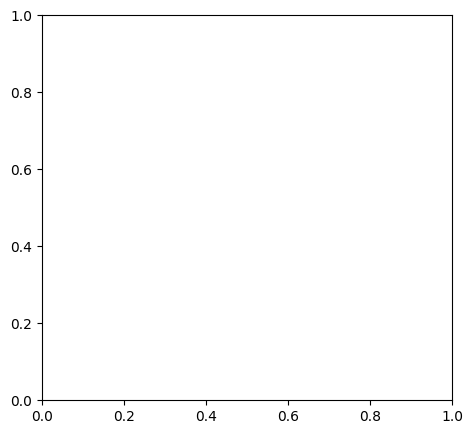

In [62]:
# --- 6. Visualisation des Courbes ---
if EPOCHS > 0: # Plot seulement si l'entraînement a eu lieu
    epochs_range = range(1, EPOCHS + 1)

    plt.figure(figsize=(18, 5))

    # Plot 1: Loss (Training vs. Validation)
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history['train_loss'], 'o-', label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], 'o-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Accuracy (Training vs. Validation)
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history['train_acc'], 'o-', label='Train Accuracy')
    plt.plot(epochs_range, history['val_acc'], 'o-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot 3: Validation F1-score (Minority Class)
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history['val_f1_minority'], 'o-', label='Validation F1 (Classe 1)', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score (Classe 1)')
    plt.title('Validation F1 Score (Minority Class)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout() # Ajuste automatiquement les subplots pour qu'ils ne se chevauchent pas
    plt.show()
else:
    print("EPOCHS = 0, pas de courbes à afficher.")


Évaluation finale du modèle sur l'ensemble de test...
Test Loss: 0.3042 | Test Accuracy: 0.8984
Métriques pour la Classe 1 (Cohérent):
  Precision: 0.6299
  Recall:    0.9417
  F1-score:  0.7549
Métriques pour la Classe 0 (Non Cohérent):
  Precision: 0.9871
  Recall:    0.8897
  F1-score:  0.9359


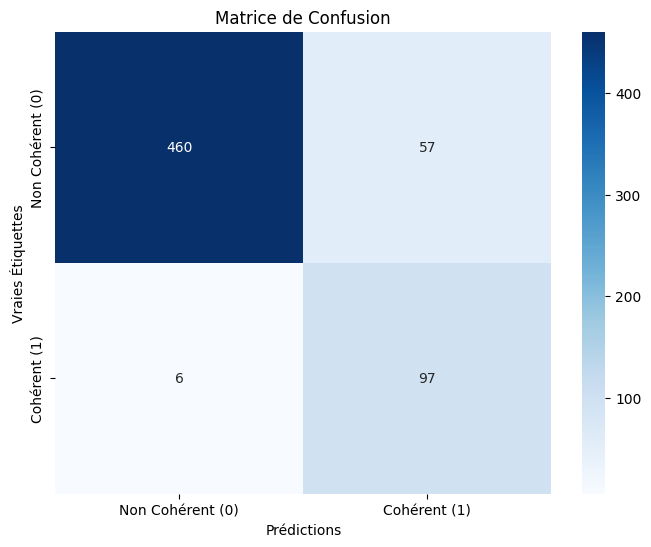

In [61]:

# --- 6. Évaluation Finale et Métriques détaillée ---

print("\nÉvaluation finale du modèle sur l'ensemble de test...")
final_test_acc, final_test_loss, true_labels, pred_labels = eval_model_fn(
    model, test_loader, device, len(test_dataset)
)
print(f'Test Loss: {final_test_loss:.4f} | Test Accuracy: {final_test_acc:.4f}')


# Spécifiez pos_label=1 pour être sûr que c'est pour la classe positive
precision_class1 = precision_score(true_labels, pred_labels, pos_label=1, zero_division=0)
recall_class1 = recall_score(true_labels, pred_labels, pos_label=1, zero_division=0)
f1_class1 = f1_score(true_labels, pred_labels, pos_label=1, zero_division=0)
print(f'Métriques pour la Classe 1 (Cohérent):')
print(f'  Precision: {precision_class1:.4f}')
print(f'  Recall:    {recall_class1:.4f}')
print(f'  F1-score:  {f1_class1:.4f}')

precision_class0 = precision_score(true_labels, pred_labels, pos_label=0, zero_division=0)
recall_class0 = recall_score(true_labels, pred_labels, pos_label=0, zero_division=0)
f1_class0 = f1_score(true_labels, pred_labels, pos_label=0, zero_division=0)
print(f'Métriques pour la Classe 0 (Non Cohérent):')
print(f'  Precision: {precision_class0:.4f}')
print(f'  Recall:    {recall_class0:.4f}')
print(f'  F1-score:  {f1_class0:.4f}')


cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Cohérent (0)', 'Cohérent (1)'], yticklabels=['Non Cohérent (0)', 'Cohérent (1)'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies Étiquettes')
plt.title('Matrice de Confusion')
plt.show()



In [ ]:
# Décoder les input_ids pour récupérer le texte
decoded_texts = [tokenizer.decode(item['input_ids'], skip_special_tokens=True) for item in test_dataset]

df_results = pd.DataFrame({
    'decoded_input': decoded_texts,
    'true_label': true_labels,
    'pred_label': pred_labels
})

# Afficher toutes les lignes (None signifie illimité)
pd.set_option('display.max_rows', None)

# Afficher toutes les colonnes si tu veux aussi
pd.set_option('display.max_columns', None)

# Afficher toute la largeur d’une colonne (pour éviter les "...")
pd.set_option('display.max_colwidth', None)

false_positives = df_results[(df_results['true_label'] == 0) & (df_results['pred_label'] == 1)]
false_negatives = df_results[(df_results['true_label'] == 1) & (df_results['pred_label'] == 0)]

print("==== FAUX POSITIFS ====") #Faux le model prédit Cohérent
print(false_positives[['decoded_input']].head())

print("\n==== FAUX NÉGATIFS ====")
print(false_negatives[['decoded_input']].head())


In [63]:
# CELLULE POUR SAUVEGARDER LE MODÈLE ET LE TOKENIZER

# --- 7. Sauvegarder le modèle final entraîné ---
MODEL_SAVE_PATH = "vr_save_model_fr/camembert_coherence_final_model.bin"
TOKENIZER_SAVE_PATH = "vr_save_model_fr/camembert_coherence_tokenizer/" # Un répertoire

# S'assurer que le modèle est sur CPU avant de sauvegarder pour une meilleure portabilité
# (Surtout si vous comptez le charger sur une machine sans GPU)
model.to('cpu')
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Modèle final (state_dict) sauvegardé sous: {MODEL_SAVE_PATH}")

# Remettre le modèle sur son device original si besoin de continuer à l'utiliser dans cette session
model.to(device)

# Sauvegarder le tokenizer (contient vocabulaire, configuration, etc.)
tokenizer.save_pretrained(TOKENIZER_SAVE_PATH)
print(f"Tokenizer sauvegardé sous: {TOKENIZER_SAVE_PATH}")

print("\nSauvegarde terminée.")

Modèle final (state_dict) sauvegardé sous: vr_save_model_fr/camembert_coherence_final_model.bin
Tokenizer sauvegardé sous: vr_save_model_fr/camembert_coherence_tokenizer/

Sauvegarde terminée.


In [64]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import re 


MODEL_NAME_FOR_TEST = "camembert-base"
MAX_LEN_FOR_TEST = 160 
MODEL_SAVE_PATH_FOR_LOAD = "vr_save_model_fr/camembert_coherence_final_model.bin"
TOKENIZER_SAVE_PATH_FOR_LOAD = "vr_save_model_fr/camembert_coherence_tokenizer/"
DEVICE_FOR_TEST = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def clean_text_for_prediction(text):
    text = str(text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s\.\?,!àâéèêëîïôûùüçÀÂÉÈÊËÎÏÔÛÙÜÇ\']', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text


model_to_test = None
tokenizer_to_test = None
device_to_test = None
max_len_to_test = None
clean_text_func_to_use = None


tokenizer_to_test = AutoTokenizer.from_pretrained(TOKENIZER_SAVE_PATH_FOR_LOAD)


model_to_test = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME_FOR_TEST, num_labels=2)

# Charger les poids sauvegardés
model_to_test.load_state_dict(torch.load(MODEL_SAVE_PATH_FOR_LOAD, map_location=DEVICE_FOR_TEST))
model_to_test.to(DEVICE_FOR_TEST)
model_to_test.eval() 

max_len_to_test = MAX_LEN_FOR_TEST 
clean_text_func_to_use = clean_text_for_prediction
device_to_test = DEVICE_FOR_TEST 

print("Modèle et tokenizer chargés depuis le disque et prêts pour l'inférence.")


c:\Simoh\Github\BERT_Response_Validity_Checker\.venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modèle et tokenizer chargés depuis le disque et prêts pour l'inférence.


In [65]:
# --- Fonction de prédiction (utilise les variables _to_test) ---
def predict_coherence(question, answer, model, tokenizer, device, max_len, clean_fn):

    cleaned_question = clean_fn(question)
    cleaned_answer = clean_fn(answer)

    encoding = tokenizer.encode_plus(
        cleaned_question,
        cleaned_answer,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        prediction_idx = torch.argmax(probs, dim=1).cpu().item()
        probability_score = probs[0][prediction_idx].cpu().item()

    return prediction_idx, probability_score


In [ ]:

# --- Exemples de test ---
test_samples = [
    {
        "question": "Bonjour, que puis-je faire pour vous aujourd'hui ?",
        "answer": "je voudrais des chaussures."
    }, # Cohérent
    {
        "question": "Bonjour, que puis-je faire pour vous aujourd'hui ?",
        "answer": "je voudrais des bananes."
    }, # Incohérent
    {
        "question": "Quelle est votre taille habituelle ?",
        "answer": "42."
    }, # Cohérent
    {
        "question": "Quelle est votre taille habituelle ?",
        "answer": "la hauteur d'un panier de basket est de 3m05."
    }, # Incohérent
    {
        "question": "Avez-vous une couleur ou un style en tête ?",
        "answer": "oui un style normal de couleur bleue."
    }, # Cohérent
    {
        "question": "Avez-vous une couleur ou un style en tête ?",
        "answer": "le vert est la couleur du kiwi."
    }, # Incohérent
    {
        "question": "Ce modèle vous plaît-il ?",
        "answer": "oui, il est parfait."
    }, # Cohérent
    {
        "question": "Ce modèle vous plaît-il ?",
        "answer": "je prend l'avion demain."
    }, # Incohérent
    {
        "question": "Souhaitez-vous essayer autre chose ou passer en caisse ?",
        "answer": "je veux payer maintenant."
    }, # Cohérent
    {
        "question": "Souhaitez-vous essayer autre chose ou passer en caisse ?",
        "answer": "payer avec une pomme c'est possible ?."
    },# Incohérent
]


for i, sample in enumerate(test_samples):
    q = sample["question"]
    a = sample["answer"]

    print(f"\nExemple {i+1}:")
    print(f"  Question: \"{q}\"")
    print(f"  Réponse:  \"{a}\"")

    pred_label, pred_prob = predict_coherence(q, a,
                                                model_to_test,
                                                tokenizer_to_test,
                                                device_to_test,
                                                max_len_to_test,
                                                clean_text_func_to_use)


    coherence_status = "Cohérent" if pred_label == 1 else "Non Cohérent"
    print(f"  Prédiction: {coherence_status} (Label: {pred_label}, Confiance: {pred_prob:.4f})")



Exemple 1:
  Question: "Bonjour, que puis-je faire pour vous aujourd'hui ?"
  Réponse:  "je voudrais des chaussures."
  Prédiction: Cohérent (Label: 1, Confiance: 0.9347)

Exemple 2:
  Question: "Bonjour, que puis-je faire pour vous aujourd'hui ?"
  Réponse:  "je voudrais des bananes."
  Prédiction: Cohérent (Label: 1, Confiance: 0.7456)

Exemple 3:
  Question: "Quelle est votre taille habituelle ?"
  Réponse:  "42."
  Prédiction: Cohérent (Label: 1, Confiance: 0.9398)

Exemple 4:
  Question: "Quelle est votre taille habituelle ?"
  Réponse:  "la hauteur d'un panier de basket est de 3m05."
  Prédiction: Non Cohérent (Label: 0, Confiance: 0.9348)

Exemple 5:
  Question: "Avez-vous une couleur ou un style en tête ?"
  Réponse:  "oui un style normal de couleur bleue."
  Prédiction: Cohérent (Label: 1, Confiance: 0.9409)

Exemple 6:
  Question: "Avez-vous une couleur ou un style en tête ?"
  Réponse:  "le vert est la couleur du kiwi."
  Prédiction: Non Cohérent (Label: 0, Confiance: 0.732